# Deep Learning

In [1]:
import random  # generate random numbers and manipulate random selections
import numpy as np  # numerical computing library
import pandas as pd  # manipulatin data structures and data analysis tools
import torch  # tensor operations and neural network computation
from torch import optim  # optimizing parameter on training neural networks
import torch.nn.functional as F  # neural network functions like activation and loss functions
from tqdm import tqdm  # show progress bar for loops

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer  # Provides pre-trained BERT models, configuration, and tokenization utilities
from nltk.tokenize import TweetTokenizer  # tweet tokenizer

from indonlu.utils.forward_fn import forward_sequence_classification  # forward pass in sequence classification tasks
from indonlu.utils.metrics import document_sentiment_metrics_fn  # evaluating document sentiment analysis
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader  # handling datasets and data loaders for document sentiment tasks


c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# CEK CUDA
def cek_cuda():
    if torch.cuda.is_available():
        print("CUDA tersedia!")
        print(f"Device name: {torch.cuda.get_device_name(0)}")
        print(f"Jumlah device: {torch.cuda.device_count()}")
    else:
        print("CUDA tidak tersedia.")

cek_cuda()

CUDA tersedia!
Device name: NVIDIA GeForce RTX 2050
Jumlah device: 1


In [10]:
"""
COMMON FUNCTION
"""


# set and assign random seed.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# count number of parameters in a model    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

# set learning rate     
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# convert metrics to string 
def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [8]:
set_seed(20240802)

## Configure and Load Pre-trained Model

In [11]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS
 
# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
count_param(model)

124443651

## Dataset Preparation

In [5]:
train_dataset_path = 'F:/dicoding-ml-terapan/sentiment-analysis/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv'
valid_dataset_path = 'F:/dicoding-ml-terapan/sentiment-analysis/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv'
test_dataset_path = 'F:/dicoding-ml-terapan/sentiment-analysis/indonlu/dataset/smsa_doc-sentiment-prosa/test_preprocess_masked_label.tsv'

In [28]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)
 
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, 
                                           max_seq_len=512, 
                                           batch_size=32, 
                                           num_workers=16, 
                                           shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, 
                                           max_seq_len=512, 
                                           batch_size=32, 
                                           num_workers=16, 
                                           shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, 
                                          max_seq_len=512, 
                                          batch_size=32, 
                                          num_workers=16, 
                                          shuffle=False)

c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [31]:
print(train_dataset[0])
print(train_loader)

(array([    2,  6540,    92,  2970,   213,  4259,  3553,   899,    34,
         259,  5590,   262,  2558,   386,   899,  1687,    26,  1574,
       30470,   899,  3310, 30468, 22130, 30360,  6123,  6368, 30468,
       22130, 30360,  2652,  1746, 30468,  8869,  6540,    34,  6315,
        1622,  1256,  8949,   899, 30468,  4222,  1622,   752,   245,
         295,  2083, 30470,  2346,  7107,   300, 30470,   405,   724,
        5189, 30470,   843, 17464,   899,   540, 10989,  3331,  1107,
       30468,   119,  3221,    79,    34,  2170,    98,  9167, 30457,
           3]), array(0, dtype=int64), 'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari te

In [32]:
label_to_index, index_to_label = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(label_to_index)
print(index_to_label)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## Model Test

In [34]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)
 
logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
 
print(f'Text: {text} | Label : {index_to_label[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (37.769%)


## Fine Tune & Evaluation

In [35]:
optimizer = optim.Adam(params=model.parameters(), lr=3e-6)
model = model.cuda()

In [36]:
# Train
n_epochs = 3
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_progressbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_progressbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model=model, 
                                                                       batch_data=batch_data[:-1],
                                                                       i2w=index_to_label,
                                                                       device='cuda')
        
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        total_train_loss = total_train_loss + train_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_progressbar.set_description("(EPOCH {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format(epoch+1,
                                                                                          total_train_loss/(i+1),
                                                                                          get_lr(optimizer)))
    
    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(| EPOCH {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
                                                               total_train_loss/(i+1),
                                                               metrics_to_string(metrics), 
                                                               get_lr(optimizer)))
 
    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []
 
    progressbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(progressbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, 
                                                                       batch_data[:-1], 
                                                                       i2w=index_to_label, 
                                                                       device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss
 
        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)
 
        progressbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(| EPOCH {}) VALID LOSS:{:.4f} {}".format((epoch+1),
                                                     total_loss/(i+1), 
                                                     metrics_to_string(metrics)))

  0%|          | 0/344 [00:00<?, ?it/s]c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
(EPOCH 1) TRAIN LOSS:

(| EPOCH 1) TRAIN LOSS:0.3474 ACC:0.87 F1:0.82 REC:0.80 PRE:0.85 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1973 ACC:0.93 F1:0.89 REC:0.87 PRE:0.92: 100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


(| EPOCH 1) VALID LOSS:0.1973 ACC:0.93 F1:0.89 REC:0.87 PRE:0.92


  0%|          | 0/344 [00:00<?, ?it/s]c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(EPOCH 2) TRAIN LOSS:0.1599 LR:0.00000300: 100%|██████████| 344/344 [09:20<00:00,  1.63s/it]


(| EPOCH 2) TRAIN LOSS:0.1599 ACC:0.95 F1:0.93 REC:0.92 PRE:0.94 LR:0.00000300


  0%|          | 0/40 [00:00<?, ?it/s]c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1720 ACC:0.93 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


(| EPOCH 2) VALID LOSS:0.1720 ACC:0.93 F1:0.90 REC:0.90 PRE:0.90


  0%|          | 0/344 [00:00<?, ?it/s]c:\Users\ubaid\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(EPOCH 3) TRAIN LOSS:0.1130 LR:0.00000300:  16%|█▌        | 54/344 [01:59<07:40,  1.59s/it] 

In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)
 
total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []
 
pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=index_to_label, device='cuda')
    list_hyp += batch_hyp
 
# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)
 
print(df)
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)
 
total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []
 
pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=index_to_label, device='cuda')
    list_hyp += batch_hyp
 
# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)
 
print(df)

## Sentiment Predict


In [ ]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)
 
logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
 
print(f'Text: {text} | Label : {index_to_label[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

# SVM Support Vector Machine

In [2]:
import pandas as pd
 
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

In [3]:
train_dataset_path = 'F:/dicoding-ml-terapan/sentiment-analysis/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv'
valid_dataset_path = 'F:/dicoding-ml-terapan/sentiment-analysis/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv'

In [4]:
data_train = pd.read_csv(train_dataset_path, sep='\t', names=['Teks', 'Target'])
data_valid= pd.read_csv(valid_dataset_path, sep='\t', names=['Teks', 'Target'])
data_train.head()

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [7]:
print(data_train.shape)
print(data_valid.shape)

(11000, 2)
(1260, 2)


In [9]:
data_train['Target'].value_counts()

Target
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

<Axes: xlabel='Target'>

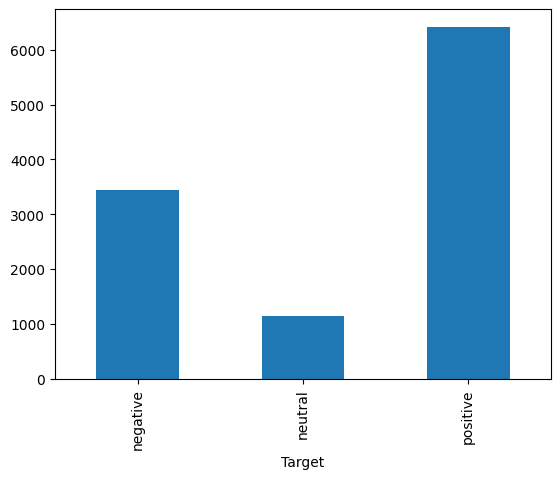

In [11]:
data_train.groupby('Target').size().plot(kind='bar')

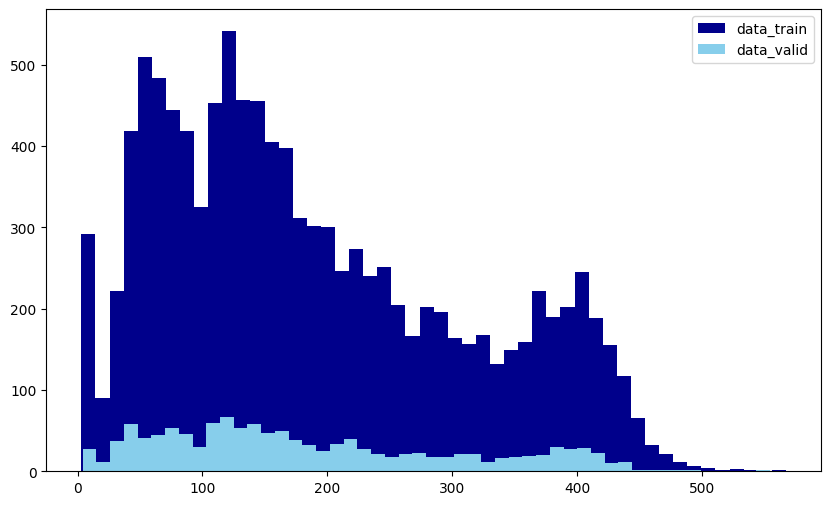

In [12]:
len_data_train = data_train['Teks'].str.len()
len_data_valid = data_valid['Teks'].str.len()

plt.figure(figsize=(10,6))
plt.hist(len_data_train, bins=50, label="data_train", color='darkblue')
plt.hist(len_data_valid, bins=50, label="data_valid", color='skyblue')
plt.legend()
plt.show()

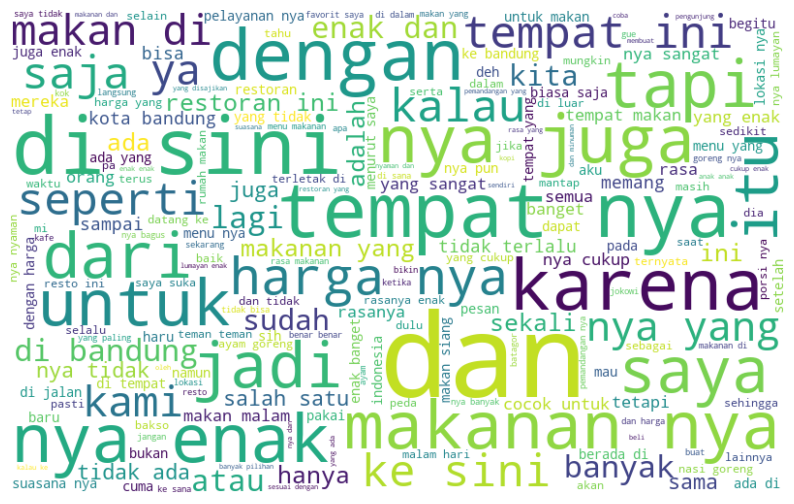

In [14]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, 
                          height=500,
                          random_state=13,
                          max_font_size=120,
                          background_color='white'
                          ).generate(words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in data_train['Teks']])
wordCloud(all_words)

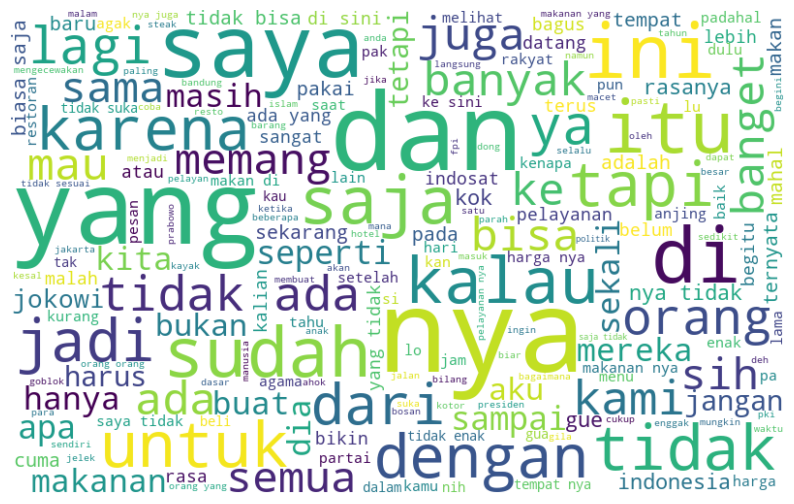

In [16]:
negative_words = ' '.join(text for text in data_train['Teks'][data_train['Target']=='negative'])
wordCloud(negative_words)

## Feature Engineering with TF-IDF

Fungsi `tfidfvectorizer` memiliki beberapa parameter, antara lain:

- `min_df`
Digunakan untuk menghilangkan term/istilah yang terlalu jarang muncul. Sebagai contoh, jika diset min_df = 0.01, artinya kita mengabaikan term yang muncul kurang dari 1% dalam teks. Jika diset min_df = 5, artinya kita mengabaikan term yang muncul dalam kurang dari 5 dokumen.

- `max_df`
Digunakan untuk menghilangkan term yang terlalu sering muncul, biasanya merupakan stop words yang telah kita bahas pada materi sebelumnya. Sebagai contoh, jika diset max_df=0.8, artinya kita mengabaikan term yang muncul lebih dari 80% dalam teks. Jika diset 25, artinya kita mengabaikan term yang muncul di lebih dari 25 dokumen.

- `sublinear_tf`
Berfungsi untuk melakukan scaling dan bernilai boolean dengan default false. Sublinear_tf=True akan mengubah vektor frekuensi menjadi bentuk logaritmik (1+log(tf)). Sehingga dapat menormalisasi bias terhadap teks yang panjang dan teks yang pendek.

- `use_idf`
Bernilai boolean dengan default True. Parameter ini memungkinkan kita untuk menggunakan Inverse Document Frequency (IDF). Hal ini berarti term yang terlalu sering muncul dalam teks akan diberi skor lebih sedikit dibanding term yang jarang muncul (hanya muncul pada teks yang spesifik saja).

Dalam proses vektorisasi ini, kita menggunakan dua metode yaitu:

- `fit_transform`
Metode ini mempelajari kosa kata dan Inverse Document Frequency (IDF) yang telah kita bahas sebelumnya. Ia memberikan nilai return berupa document-term matrix.

- `transform`
Metode ini mentransformasi dokumen ke dalam document-term matrix.

In [17]:
vectorizer = TfidfVectorizer(min_df=5,
                             max_df=0.8,
                             sublinear_tf=True,
                             use_idf=True
                             )
train_vectors = vectorizer.fit_transform(data_train['Teks'])
valid_vectors = vectorizer.transform(data_valid['Teks'])

In [18]:
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, data_train['Target'])
prediction_linear = classifier_linear.predict(valid_vectors)

In [19]:
target_names = ['positive', 'negative', 'netral']
print(classification_report(data_valid['Target'], prediction_linear, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.81      0.86      0.84       394
    negative       0.79      0.70      0.74       131
      netral       0.92      0.91      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.87      0.87      0.87      1260



In [20]:
teks = """Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita"""
teks_vector = vectorizer.transform([teks]) # vectorizing
print(classifier_linear.predict(teks_vector))

['positive']


In [28]:
teks_test = ["Ronaldo pergi ke Mall Grand Indonesia membeli cilok",
             "Sayang, aku marah",
             "Merasa kagum dengan toko ini tapi berubah menjadi kecewa setelah transaksi",
             "rusak tapi berjalan baik"]
for teks in teks_test:
    teks_vector = vectorizer.transform([teks])
    print(classifier_linear.predict(teks_vector))

['neutral']
['negative']
['negative']
['negative']
